<img style="border:2px solid black;" src="accueil.png" width=100% border="5"> </center> 
# <span style="color:blue">Porous Media - Flow modelling tools using Jupyter </span>
## <span style="color:red"> PYGRDECL based Upscaling notebook </span>

## <span style="color:blue"> 1. Create initial GRDECL ECLIPSE/PETREL Pillar Grid </span>

In [1]:
from GRDECL2VTK import *

# 1.1 Set physical dimensions in physDims (m)
physDims=[2000.0,1000,500]

# 1.2 Set model grid dimensions in gridDims
Nx=30;  Ny=30;  Nz=Nx
gridDims=[Nx,Ny,Nz]

# 1.3 Set corner point grid options
opt=buildCPGGrid_opt(disturbed=False,     flat=True,\
                     fault_drop=300 , fault_nx=Nx//2)

# 1.4 Create empty GeologyModel - Build CPG
Model=GeologyModel()
Model.buildCPGGrid(physDims,gridDims,opt)

# 1.5 Compute First TPFA (block centered) Pressure values
import time
t0=time.time()
# Model.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt )
# print("Elapsed time for TPFA: ",time.time()-t0)
# # Model.plot_scalar("Pressure",ITK=True).show()

     Creating Grid:
       Type: CornerPoint Grid
       Grid Dimensions (NX,NY,NZ): (30 x 30 x 30)
       Number Of Grid Cells: 27000
       Created: Fields: ***PERMX***PERMY***PERMZ***PORO***


## <span style="color:blue"> 2. Generate  synthetic Porosity/Permeability(mD) values </span>

[logNormLayers] Filling K and Phi Z layers with log normal distributions
[logNormLayers] Done
[UpdateListCellData] varname:PORO
[UpdateListCellData] varname:PERMX
[UpdateListCellData] varname:PERMY
[UpdateListCellData] varname:PERMZ


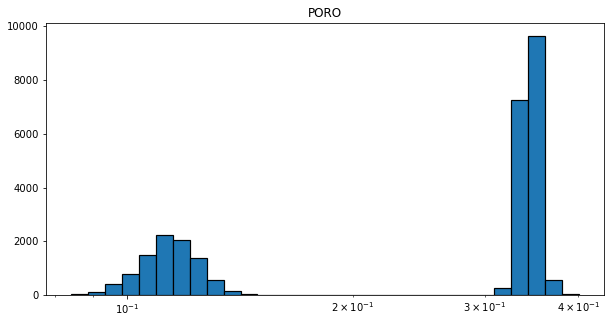

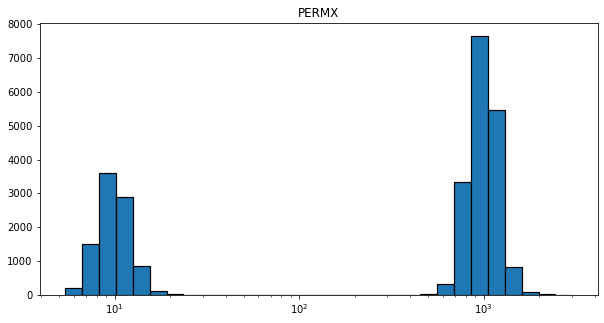

In [2]:
from utils import *

# 2.1 Create random perm field with normal distribution for each layer
K_LayerPerm=[10,1000,10,1000]
# K,phi=logNormLayers(gridDims,K_LayerPerm,poro_const=0.05)
K,phi=logNormLayers_basc(gridDims,K_LayerPerm,poro_const=0.05)

# 2.2 Update porosity/permeability fields
Update_fields=["PORO","PERMX","PERMY","PERMZ"]
Update_values=[ phi  , K     , K     , 0.1*K ]
Model.UpdateListCellData(var_list=Update_fields,array_list=Update_values)

# 2.3 Visualize Fine scale histogram
for scalar in ["PORO","PERMX"]:
    plot_hist(Model.GRDECL_Data.SpatialDatas[scalar], varname=scalar)

# 2.3 Compute TPFA (block centered) Pressure values
# Model.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt )
# Model.plot_scalar("Pressure",ITK=True).show()

## <span style="color:blue"> 3. Create coarse grid by partitoning fine gride</span>

In [3]:
# List of implemented upscaling methods
methods=Model.Upscaler.list_upscaling_methods()
print(methods)

['Arithmetic_mean', 'Geometric_mean', 'Harmonic_mean', 'Harmx_mean', 'Harmy_mean', 'Harmz_mean', 'TPFA_loc', 'TPFA_glob', 'TPFA_loc_vol_average']


[Partioning] Partitoning from Fine grid of size: [30,30,30] to Coarse grid of size: [10,10,10]


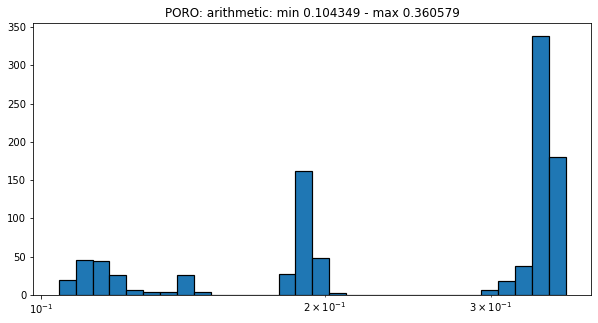

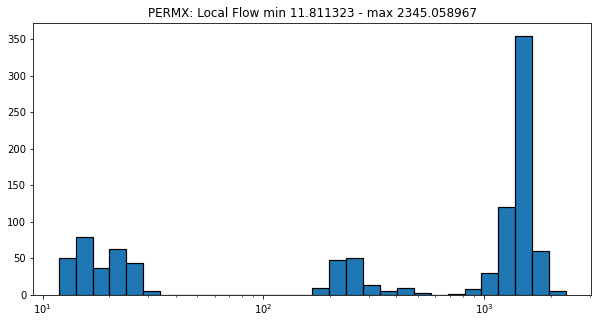

In [4]:
# 3.1 Set coarsening factor (grid dimensions of coarse cells)
Model.GRDECL_Data.coarse2fine_ratio=[3]*3

# 3.2 Create coarse grid and upscale porosity
Model2=Model.create_coarse_model()
Model.Upscale_Perm('TPFA_loc')

# 3.3 Compute Pressure for coarse model
# Model2.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt )
# # Model.two_plots_scalar("Pressure").show(False)
# Model2.plot_scalar("Pressure").show()



In [5]:
def getI_J_K(ijk,NX,NY,NZ):
    #Find index [i,j,k] from a flat 3D matrix index [i,j,k]
    i,j,k=0,0,0
    
    i=ijk%NX
    j=((int)(ijk / NX)) % NY
    k=(int)(ijk / (NX*NY))    
    return i,j,k


In [12]:
ind=10
FGrid=Model.GRDECL_Data
CGrid=Model2.GRDECL_Data




In [13]:
Model3=Model.create_local_model(ind)
print(Model.Upscaler.Glob_ind)

nlayer=1
P=FGrid.create_partition_indices_layered(CGrid,nlayer)
Glob_ind_layer=np.where(P==ind)[0]
print(Glob_ind_layer)
# Model3.plot_scalar("PORO",ITK=True).show()

[  90   91   92  120  121  122  150  151  152  990  991  992 1020 1021
 1022 1050 1051 1052 1890 1891 1892 1920 1921 1922 1950 1951 1952]
[Partioning] Partitoning from Fine grid of size: [30,30,30] to Coarse grid of size: [10,10,10]
[  60   61   90   91  120  121  960  961  990  991 1020 1021]


In [8]:
l=np.ones((3))
print(l)
i=0
np.sum(l[:i])

[1. 1. 1.]


0.0